# Convolutional Neural Network
Here, we will build and train a CNN on the actual pixel images.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Because I got more and more interested in network architecture (how many layers, what size of filters, what combination of layers makes sense etc.), I read about **AlexNet** in the [original paper by Krizhevsky, Sutskever, Hinton,](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) as one of the first and most important advances in image classification with deep convolutional neural nets. 

As a result, I wanted to try and implement the model proposed in the paper in an adjusted way for our image classification case here.

The model in the paper consists of 8 layers: 5 convolutional layers and 3 fully connected layers.

In the paper, the authors also propose the `RelU` activation function which we learned in our course here, they also include pooling layers as well as dropout regularization. 

In AlexNet, the last fully connected layer is fed to a 1000-way softmax regression, which in our case will be a 6-way softmax regression as we only have 6 possible classes to classify. 

AlexNet uses 2 parallel GPUs to train the model, and therefore the authors decided to connect only some layers to some GPUs. All of this will not be implemented here as I don't have a valid GPU in my laptop (13 inch Macbook Pro, late 2013 version). 

In the MobileNet V2, as well as in this paper, 224x224 pixel input images were used. However, [other sources, e.g. on Learn OpenCV](https://www.learnopencv.com/understanding-alexnet/) say that the printed 224x224 number was a mistake and it was actually meant to use 227x227 images. I will adjust my CNN to use 227x227 input images because all following numbers in the paper are based on 227x227 and make sense in the end.

My adjusted ConvNet will consist of:
* First convolutional layer which filters the `227x227x3` input image with 96 kernels of size `11x11x3` with `stride = 4`. 
* The output of this layer will be `55x55x96`, which will be put through a max-pooling layer of size `3x3` and `stride = 2`
    * The output will be `27x27x96`.
* Second convolutional layer will filter the last output with 256 kernels of size `5x5` and `padding = SAME`
    * The output will be `27x27x256`
* Another max-pooling layer will be applied here with pool size `3x3` and `stride = 2`
    * The output will be `13x13x256` 
* Then, 3 additional convolutional layers are following without any intervening pooling layers
    * The first will have 384 kernels of size `3x3` and `padding = SAME`, `strides = 1` --> keeps same height and length dimensions
    * The second will have 384 kernels of size `3x3` and `padding = SAME`, `strides = 1` --> keeps same height and length dimensions
    * The third will have 256 kernels of size `3x3` and `padding = SAME`, `strides = 1` --> keeps same height and length dimensions
* Then, a final max-pooling layer will follow to the current size `13x13x256` output. Pooling size will be `3x3` with `stride = 2`
* The output of size `6x6x256` will go into 3 fully connected dense layers which each have 4096 neurons.
* The last layer will apply softmax regression to have 6 possible units as output, all other layers will use ReLU activation functions
* Dropout, as described in the paper, is used for the first 2 of the 3 fully connected layers

In [2]:
# load images from directory as we are now working with the actual pixel images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255 # rescale the images to a 0-1 range
                                    ) # no need for validation split as we have a separate set

valid_generator = ImageDataGenerator(rescale = 1/255)

test_generator = ImageDataGenerator(rescale = 1/255)

# use flow_from_directory to read-in the images
trainset = train_generator.flow_from_directory("/Users/Ingo/Python Files/Course-project4/swissroads/train",
                                              target_size = (227, 227) # resize images to desired shape
                                              )
validset = valid_generator.flow_from_directory("/Users/Ingo/Python Files/Course-project4/swissroads/valid",
                                              target_size = (227, 227))

testset = test_generator.flow_from_directory("/Users/Ingo/Python Files/Course-project4/swissroads/test",
                                             target_size = (227, 227))

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [3]:
# check shape of input
feature_batch, label_batch = trainset.next()

print("feature batch shape:", feature_batch.shape)
print("label batch shape:", label_batch.shape)

feature batch shape: (32, 227, 227, 3)
label batch shape: (32, 6)


We can see that we already have the needed 4-dimensional shape comprising of: `number of imgs, dim, dim, channels` 
___
Now we can start and build the model using the Keras API

In [4]:
# create the model
cnn = keras.Sequential()

# set seed to 0
np.random.seed(0)

# add layeres
# first layer
cnn.add(keras.layers.Conv2D(filters = 96, # 96 filters
                           kernel_size = (11, 11), # 11x11 kernel
                           strides = 4,
                           padding = "SAME", # same padding
                           activation = "relu", # ReLU activation
                           input_shape = [227, 227, 3] # 227x227 RGB images
                           ))

# max pooling layer
cnn.add(keras.layers.MaxPool2D(pool_size = (3, 3), # 3x3 pool size
                              strides = 2))

# second convolutional layer
cnn.add(keras.layers.Conv2D(filters = 256, # 256 filters will be used
                           kernel_size = (5, 5), # 5x5 filter size
                           strides = 1,
                           padding = "SAME", # stride = 1 and padding = SAME will keep output dims equal
                           activation = "relu"))

# second max-pooling layer
cnn.add(keras.layers.MaxPool2D(pool_size = (3, 3), # 3x3 pool size
                              strides = 2))

# third convolutional layer
cnn.add(keras.layers.Conv2D(filters = 384, # 384 filters
                           kernel_size = (3, 3),
                           strides = 1,
                           padding = "SAME", # keep same height and length dimensions
                           activation = "relu"))

# fourth convolutional layer
cnn.add(keras.layers.Conv2D(filters = 384, # 384 filters again
                           kernel_size = (3, 3), # size 3x3 filters
                           strides = 1,
                           padding = "SAME", # padding = SAME and strides = 1 keep the dimensions
                           activation = "relu"))

# fifth convolutional layer
cnn.add(keras.layers.Conv2D(filters = 256, # 256 filteres now
                           kernel_size = (3, 3), # size 3x3 filters
                           strides = 1,
                           padding = "SAME",
                           activation = "relu"))

# final max-pooling layer
cnn.add(keras.layers.MaxPool2D(pool_size = (3, 3), # 3x3 max-pooling layer
                              strides = 2)) # will reduce size to output 6x6x256

# now, only fully-connected layers follow

# flatten the layers
cnn.add(keras.layers.Flatten())

# first dense layer WITH dropout regularization
cnn.add(keras.layers.Dropout(rate = 0.5, seed = 0))
cnn.add(keras.layers.Dense(units = 4096, # we will put out 4096 artificial neurons
                          activation = "relu", # still ReLU activation function
                          ))

# second dense layer WITH dropout
cnn.add(keras.layers.Dropout(rate = 0.5, seed = 0))
cnn.add(keras.layers.Dense(units = 4096,
                          activation = "relu"))

# third dense layer without dropout
cnn.add(keras.layers.Dense(units = 6, # 6 output classes
                          activation = "softmax"))

# get summary of model
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)       884992    
__________

As we can see here, our model has 58.3 million trainable parameter, which would take quite long to train if our input wasn't only 280 images in the train set.

Let's define the loss and optimization functions

In [5]:
# define loss and optimization
cnn.compile(optimizer = "sgd", # use stochastic gradient descent algorithm
           loss = "categorical_crossentropy", # our input is already one-hot-encoded, so no sparse_cat..
           metrics = ["acc"], # track accuracy values
           )

In [6]:
# define an early stop as we have a big model
callback = keras.callbacks.EarlyStopping(monitor = "val_loss", # target variable to minimize
                                        patience = 6 # stop after 6 epochs with no loss improvement
                                        )

In [7]:
# train the model
# need to use fit_generator as we have our input data in generators
history = cnn.fit_generator(generator = trainset, validation_data = validset,
                           epochs = 100, # upper limit of epochs to train
                           callbacks = [callback] # stop early when defined callback is reached
                           )

Epoch 1/100
9/9 [==============================] - 40s 4s/step - loss: 1.7893 - acc: 0.1943 - val_loss: 1.7824 - val_acc: 0.2374
Epoch 2/100
9/9 [==============================] - 35s 4s/step - loss: 1.7734 - acc: 0.2514 - val_loss: 1.7697 - val_acc: 0.2374
Epoch 3/100
9/9 [==============================] - 34s 4s/step - loss: 1.7720 - acc: 0.2260 - val_loss: 1.7597 - val_acc: 0.2374
Epoch 4/100
9/9 [==============================] - 35s 4s/step - loss: 1.7533 - acc: 0.2326 - val_loss: 1.7472 - val_acc: 0.2374
Epoch 5/100
9/9 [==============================] - 34s 4s/step - loss: 1.7465 - acc: 0.2211 - val_loss: 1.7412 - val_acc: 0.2374
Epoch 6/100
9/9 [==============================] - 34s 4s/step - loss: 1.7466 - acc: 0.2570 - val_loss: 1.7399 - val_acc: 0.2374
Epoch 7/100
9/9 [==============================] - 34s 4s/step - loss: 1.7394 - acc: 0.2336 - val_loss: 1.7364 - val_acc: 0.2374
Epoch 8/100
9/9 [==============================] - 34s 4s/step - loss: 1.7397 - acc: 0.2576 - val

The training process stopped after 78 epochs, i.e. it has trained 78 times on the whole 280 images. After a `patience = 6` waiting period, the process stopped due to the early callback. This means that our model metric `val_loss` wasn't improving (--> decreasing) anymore for 6 epochs and thus can't learn more from the fed training data. 

To get a perspective of how much the model improved / "learned" in the 78 epochs, let's plot the loss and accuracy of both training and validation values

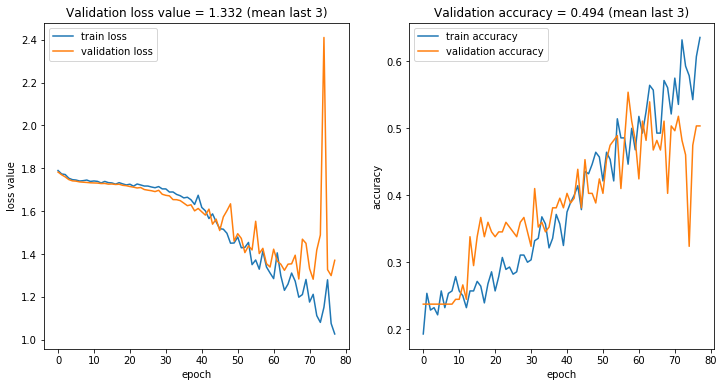

In [8]:
# plot the results
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

# first plot is loss comparison
ax1.plot(history.history["loss"], label = "train loss")
ax1.plot(history.history["val_loss"], label = "validation loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss value")
ax1.legend()
ax1.set_title("Validation loss value = {:.3f} (mean last 3)".format(np.mean(
    history.history["val_loss"][-3:])))

ax2.plot(history.history["acc"], label = "train accuracy")
ax2.plot(history.history["val_acc"], label = "validation accuracy")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()
ax2.set_title("Validation accuracy = {:.3f} (mean last 3)".format(np.mean(
    history.history["val_acc"][-3:])))

plt.show()

We can see a clear decrease in training and validation loss value in the first 40 epochs, which indicates that the model learned a lot there. Then, there were spikes during which the loss value spiked to bigger loss values, indicating that the model variance increased during that times. The spikes got larger and larger with continuing epochs, first on the validation set, then on the training set aswell. However, the spikes in the validation set are always bigger.
> I am not sure how to accurately interpret the spikes, especially the very large one, i.e. why they happended, why they happend at that moment, etc.

Regarding accuracy, we can observe a varying curve but with a clear trend upwards until around 60 epochs. At that time, the variances got so large that it isn't clear anymore whether the validation accuracy continues to rise or drop. From epoch 60 to epoch 78, the model starts to overfit. Training accuracy rises - but also with large variances of ~10 percentage points - but validation accuracy at the same time starts to vary ~20 percentage points or more.

Let's evaluate the test accuracy of our convolutional neural network

In [9]:
# get test accuracy
test_loss, test_accuracy = cnn.evaluate_generator(testset)

print("test accuracy:", test_accuracy)

test accuracy: 0.5599999976158142


In general, our model reaches accuracies of ~56%, which is pretty impressive (**in this case, of course, the achievement of AlexNet, which has been researched and engineered by experts of the field**) considering a training sample size of only 280 images.

Still, the model doesn't reach accuracies that are comparable to our other successful models, such as k-NN, logistic regression, or svm with rbf kernel. 

The difference, however, is that we trained a model here on the actual pixel values of the raw images. In all other models, we used the outputs of a pre-trained, highly complex model which did most of the work for us, i.e. extracting the valuable patterns and handing us those patterns in easily interpretable, numerical form for other models to pick up on. Our models were presented with numerical values that another model found out. As a consequcence, we were able to get good results (~96% accuracy) with only 280 training images.

Here, it makes sense that our accuracy stays in the lower ranges because we only have 280 images to train on. Probably very few models - if any - would get consistently good results (90%+ accuracy) with only 280 images/data points to train on. As far as I know, this is exactly the general problem with deep learning and neural nets: you need data en masse to train, validate, and test your models; and often times - e.g. in medical imaging - the data isn't readily available. As a result, it is difficult to create robust models in which you can place a lot of trust in critical situations.

As a point of comparison, our other models trained on e.g. MNIST, had several thousand images available. To get good results in more complex RGB images, we would need at least the same amount of images, i.e. several thousands, to get comparable results.

In [10]:
import pandas as pd

# save the accuracy in a csv file
save_df = pd.DataFrame({
    "model": ["cnn"],
    "test_accuracy": [test_accuracy]
})

save_df.to_csv("/Users/Ingo/Python Files/Course-project4/07_conv-neural-net.csv",
              index = False)